In [35]:
# %pip install wandb -q
# %pip install sentencepiece -q
# %pip install pyngrok


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 2.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19868 sha256=9fdb8cc9b2845d6ec208923ba50901b8689635195abf481ffc96a31fabbb454c
  Stored in directory: /home/sid98/.cache/pip/wheels/b6/2f/3d/4957f583fdfd1c359843d2e57981c634692c579788b2dfc088
Successfully built pyngrok
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import argparse

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import torch
import pytorch_lightning  as pl
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader

from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import load_metric
import torch.optim as optim
from pytorch_lightning.callbacks import ModelCheckpoint

from pytorch_lightning.loggers import WandbLogger

In [5]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sidb98. Use `wandb login --relogin` to force relogin


True

In [6]:
train_data = load_dataset("cnn_dailymail", "3.0.0", split="train[:2%]")    #143556 
val_data = load_dataset("cnn_dailymail", "3.0.0", split="validation[:50%]")   #13368 
test_data = load_dataset("cnn_dailymail", "3.0.0", split="test[:30%]") #11490

print(len(train_data), len(val_data), len(test_data))

Found cached dataset cnn_dailymail (/home/sid98/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)
Found cached dataset cnn_dailymail (/home/sid98/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)
Found cached dataset cnn_dailymail (/home/sid98/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


5742 6684 3447


In [7]:
MODEL_NAME = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [6]:
text_token_counts, summary_token_counts = [], []
for i in range(len(train_data)):
    if i % 1000 == 0:
        print(i)
    text_token_counts.append(len(tokenizer.encode(train_data[i]['article'])))
    summary_token_counts.append(len(tokenizer.encode(train_data[i]['highlights'])))

Token indices sequence length is longer than the specified maximum sequence length for this model (636 > 512). Running this sequence through the model will result in indexing errors


0
1000
2000
3000
4000
5000


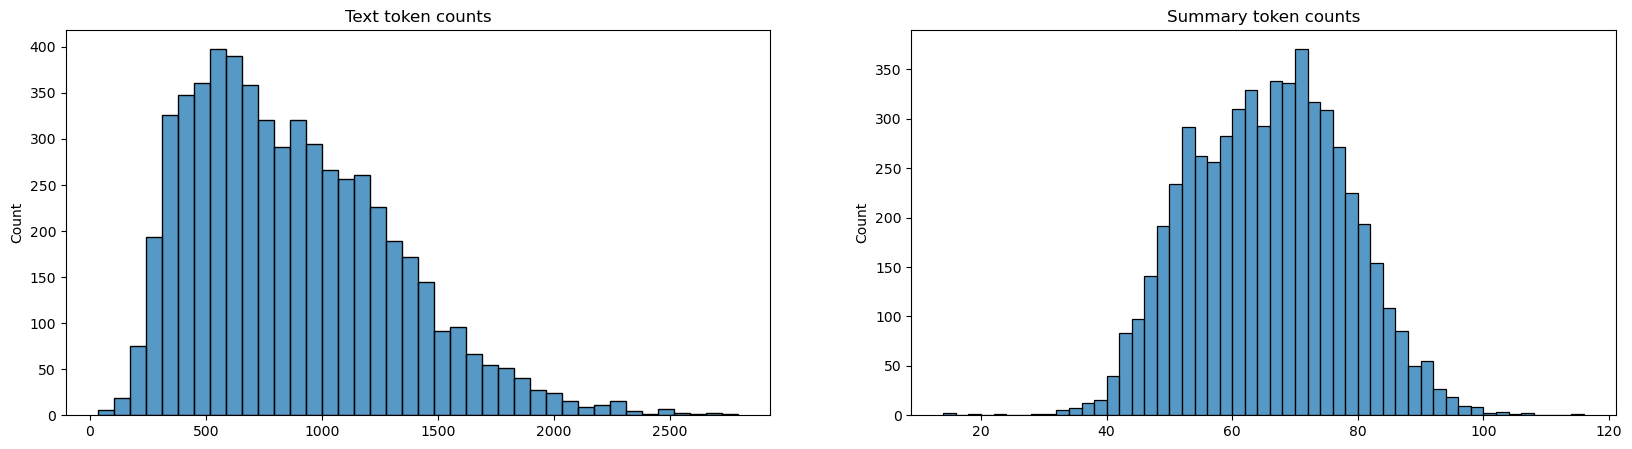

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(text_token_counts, ax=ax1)
sns.histplot(summary_token_counts, ax=ax2)
ax1.set_title("Text token counts")
ax2.set_title("Summary token counts")
plt.show()

In [8]:
def show_sample(dataset, num_sample=3,seed=42):
    wrapper = textwrap.TextWrapper(width=100)
    sample = dataset.shuffle(seed=seed).select(range(num_sample))
    for example in sample:
        article = wrapper.fill(example["article"])
        summary = wrapper.fill(example["highlights"])
        print(f"Article:\n{article}\n")
        print(f"Summary:\n{summary}\n")
        print("="*100)

show_sample(train_data)

Article:
(CNN) -- Indian telecom services provider Bharti Airtel Limited and South Africa's MTN Group Limited
have renewed merger talks with the aim of creating an emerging market telecom giant, both companies
announced Monday. Bharti Enterprises chairman and group chief executive officer Sunil Bharti Mittal
in New Delhi in November . Such a merger would create an operator with combined revenues of over $20
billion and a combined customer base of over 200 million, according to both companies. In addition
to savings, "this opportunity also represents a first of its kind in developing an Indian-African
initiative that would serve as a shining example of South-South cooperation," said Bharti chairman
and managing director Sunil Bharti Mittal. MTN CEO Phuthuma Nhleko called the case for such a deal
"highly compelling," saying, a merged company would have "leading positions in three of the fastest
growing wireless markets globally -- India, Africa and the Middle East, with no overlapping
fo

In [9]:
class NewsArticleDataset(Dataset):
    def __init__(self, data, tokenizer, max_input_length, max_output_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        article = self.data[index]['article']
        summary = self.data[index]['highlights']

        tokenized_article = self.tokenizer(
            article,
            max_length=self.max_input_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        tokenized_summary = self.tokenizer(
            summary,
            max_length=self.max_output_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        source_ids = tokenized_article["input_ids"].squeeze()
        target_ids = tokenized_summary["input_ids"].squeeze()

        src_mask = tokenized_article["attention_mask"].squeeze()
        target_mask = tokenized_summary["attention_mask"].squeeze()

        return {
            "source_ids": source_ids.to(dtype=torch.long),
            "source_mask": src_mask.to(dtype=torch.long),
            "target_ids": target_ids.to(dtype=torch.long),
            "target_mask": target_mask.to(dtype=torch.long),
        }


In [10]:
from torch.utils.data import DataLoader

class NewsArticleDataModule(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, tokenizer, max_input_length, max_output_length, batch_size=32):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = NewsArticleDataset(self.train_data, self.tokenizer, self.max_input_length, self.max_output_length)
        self.val_dataset = NewsArticleDataset(self.val_data, self.tokenizer, self.max_input_length, self.max_output_length)
        self.test_dataset = NewsArticleDataset(self.test_data, self.tokenizer, self.max_input_length, self.max_output_length)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=20)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)


In [8]:
class T5Model(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        self.model = T5ForConditionalGeneration.from_pretrained(self.hparams.model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(self.hparams.model_name)
        self.rouge_metric = load_metric("rouge")
            
    def _step(self, batch):
        labels = batch["target_ids"]
        labels[labels[:,:] == self.tokenizer.pad_token_id] = -100
        loss, outputs = self(
            input_ids = batch["source_ids"],
            attention_mask = batch["source_mask"],
            labels = labels
        )
        return loss, outputs
    
    # def _generative_step(self, batch):
    #     labels = batch["target_ids"]
    #     labels[labels[:,:] == self.tokenizer.pad_token_id] = -100
    #     generated_ids = self.model.generate(
    #         batch["source_ids"],
    #         attention_mask = batch["source_mask"],
    #         decoder_attention_mask = batch['target_mask'],
    #         max_length = 150,
    #         num_beams = 2,
    #         repetition_penalty = 2.5,
    #         length_penalty = 1.0,
    #         early_stopping = True
    #     )
    #     preds = [self.tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
    #     target = [self.tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in batch["target_ids"]]
    #     loss = self._step(batch)
    
    def training_step(self, batch, batch_idx):
        loss, outputs = self._step(batch)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, outputs = self._step(batch)
        self.log("val_loss", loss, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        loss, outputs = self._step(batch)
        self.log("test_loss", loss, prog_bar=True)
        return loss
    
    def genrate_summary(self, text):
        input_ids = self.tokenizer.encode(
            text,
            padding="max_length",
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        generated_ids = self.model.generate(
            input_ids,
            max_length = 150,
            num_beams = 2,
            repetition_penalty = 2.5,
            length_penalty = 1.0,
            early_stopping = True
        )
        preds = [self.tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
        return preds


    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.lr)

In [15]:
hparam = {
    "model_name": "t5-small",
    "lr": 1e-4
}

hparam = argparse.Namespace(**hparam)

model = T5Model(hparam)

In [13]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

In [14]:
MAX_INPUT_LENGTH = 512
MAX_OUTPUT_LENGTH = 150
BATCH_SIZE = 1

wandb_logger = WandbLogger(project="t5-news-article-summarization", log_model=True)
data_module = NewsArticleDataModule(train_data, val_data, test_data, tokenizer, MAX_INPUT_LENGTH, MAX_OUTPUT_LENGTH, BATCH_SIZE)

trainer = pl.Trainer(logger=wandb_logger,callbacks=[checkpoint_callback], max_epochs=1, accelerator='auto', precision='16-mixed')

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model, data_module)
wandb.finish()

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/sid98/miniconda3/envs/pytorch-light/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /mnt/c/Users/siddh/Desktop/Projects/PyTorch/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5

Sanity Checking: 0it [00:00, ?it/s]

/home/sid98/miniconda3/envs/pytorch-light/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 5742: 'val_loss' reached 2.07486 (best 2.07486), saving model to '/mnt/c/Users/siddh/Desktop/Projects/PyTorch/checkpoints/best-checkpoint-v1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▇▄▅▁▄▄▄▂▃▃▃▆▆▆▃▅▇▃▆▆▅▃▃▂▃▅▆▄▁▂▁▃▄█▃▄▄▅▆▅
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,▁
epoch,0
train_loss,2.57421
trainer/global_step,5741
val_loss,2.07486


In [9]:
#load best model from checkpoint
best_model_path = "checkpoints/best-checkpoint-v1.ckpt"
best_model = T5Model.load_from_checkpoint(best_model_path)
best_model.eval().to("cpu")

/tmp/ipykernel_31573/3776935785.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  self.rouge_metric = load_metric("rouge")


T5Model(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(32128, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=512, out_features=512, bias=False)
                (k): Linear(in_features=512, out_features=512, bias=False)
                (v): Linear(in_features=512, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=512, out_features=2048, bias=False)
                (wo): Linear(in_features=204

In [10]:
input_text = "The stock market had a volatile day as investors reacted to the latest economic news. The Federal Reserve announced a cut in interest rates, which initially boosted investor confidence. However, concerns about global trade tensions led to a sell-off in the afternoon. Analysts are closely watching the upcoming earnings reports to gauge the health of the economy."

summary = best_model.genrate_summary(input_text)
print(summary)

['Stock market had a volatile day as investors reacted to latest economic news. The Federal Reserve announced a cut in interest rates, which initially boosted investor confidence.']
